# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

import seaborn as sns

import os


from statsmodels.graphics.tsaplots import plot_acf

import statsmodels


from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as transforms
from pyro.infer import MCMC, NUTS
import arviz as az

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

In [3]:
Device = 'cpu'

# Data

In [4]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


# L.MGP

In [5]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

In [6]:
MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=20, device=Device,disable_progbar=False)

 35%|███▌      | 1753/5000 [04:12<07:47,  6.94it/s, loss=-2.23]


# Inference

In [7]:
test_x[row_idx]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

In [9]:
bounds = bound.get_bounds(local_train_x)

## 1 Group (2 parameters)

In [11]:
def run_mcmc_Uniform_group(Pre_function, Models, Likelihoods,
                             row_idx, test_y, bounds,
                             true_params, groupN,
                             num_sampling=2000, warmup_step=1000,
                             num_chains=1, device='cpu'):
    if not (1 <= groupN <= 5):
        raise ValueError("groupN should between 1-5")

    test_y = test_y.to(dtype=torch.float32, device=device)
    true_params = torch.as_tensor(true_params, dtype=torch.float32, device=device)

    bounds = [
        (
            torch.tensor(lo, dtype=torch.float32, device=device),
            torch.tensor(hi, dtype=torch.float32, device=device),
        )
        for lo, hi in bounds
    ]

    sample_idx = list(range(2 * groupN))

    def model():
        theta = true_params.clone()

        for k in sample_idx:
            lo_k, hi_k = bounds[k]
            theta_k = pyro.sample(f"param_{k}", dist.Uniform(lo_k, hi_k))
            theta[k] = theta_k

        pred_dist = Pre_function(Models, Likelihoods, theta.unsqueeze(0))
        pyro.sample("obs", pred_dist, obs=test_y[row_idx])


    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_sampling,
        warmup_steps=warmup_step,
        num_chains=num_chains,
    )
    mcmc.run()
    return mcmc



In [ ]:
true_params = test_x[row_idx].numpy()
groupN = 2

mcmc_result_1 = run_mcmc_Uniform_group(
    Prediction.preds_distribution_fast_pred_var, MultitaskGP_models, MultitaskGP_likelihoods, 
    row_idx, test_y_21, bounds, 
    true_params, groupN, 
    num_sampling=2000, warmup_step=1000, num_chains=1, device=Device
    )

Sample: 100%|██████████| 3000/3000 [06:33,  7.62it/s, step size=8.07e-01, acc. prob=0.870]


In [23]:
samples_1 = mcmc_result_1.get_samples()

torch.save(samples_1, "mcmc_samples_group_1.pt")

In [9]:
loaded_samples_chain1 = torch.load("mcmc_samples_group_5.pt", map_location=Device)

/tmp/ipykernel_1209439/2461514526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_samples_chain1 = torch.load("mcmc_samples_group_5.pt", map_location=Device)


param_8: R-hat = 1.000, split R-hat = 1.000, ESS = 6604.4


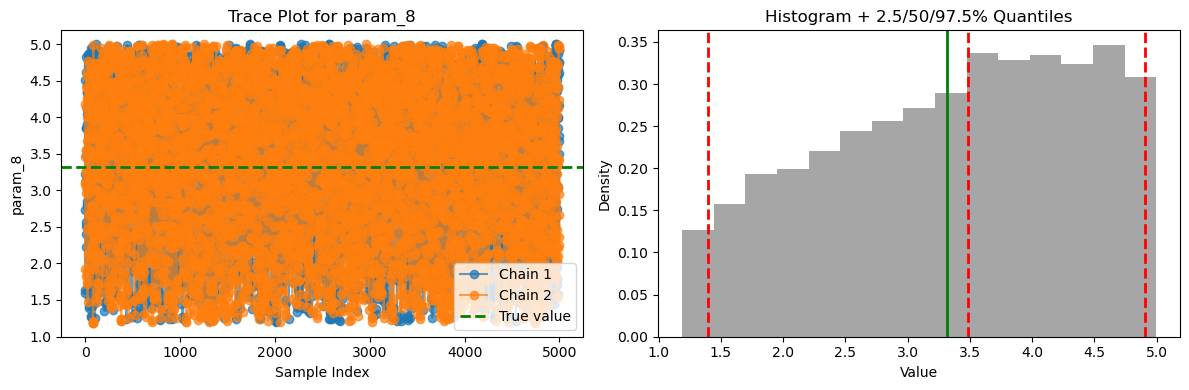

<Figure size 600x400 with 0 Axes>

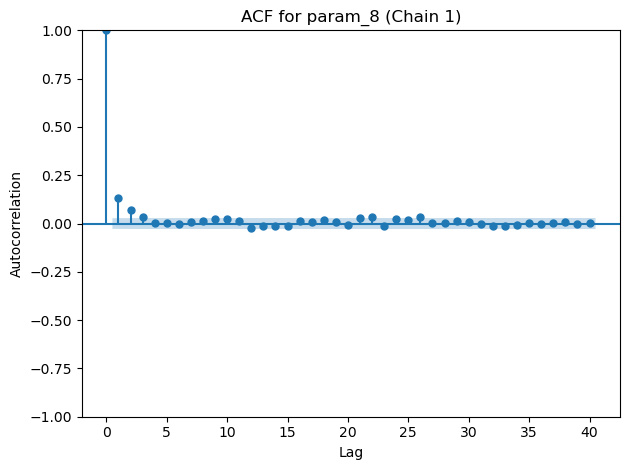

param_9: R-hat = 1.001, split R-hat = 1.000, ESS = 6179.1


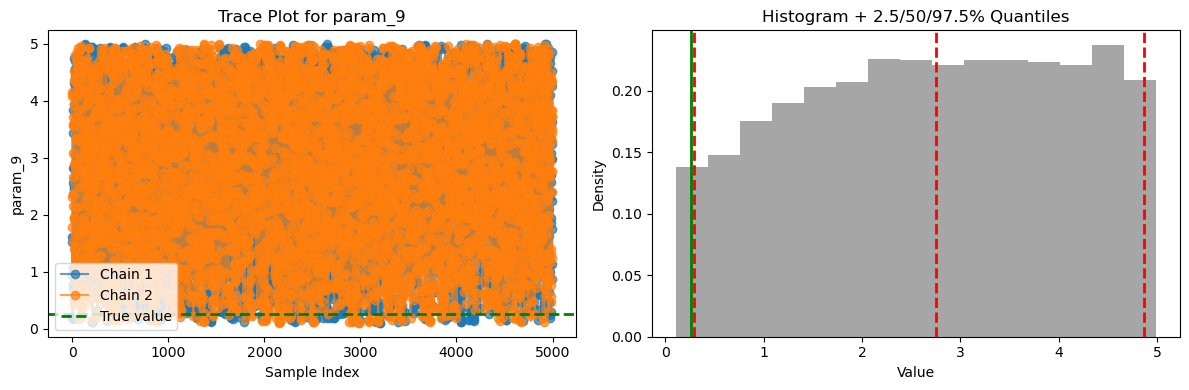

<Figure size 600x400 with 0 Axes>

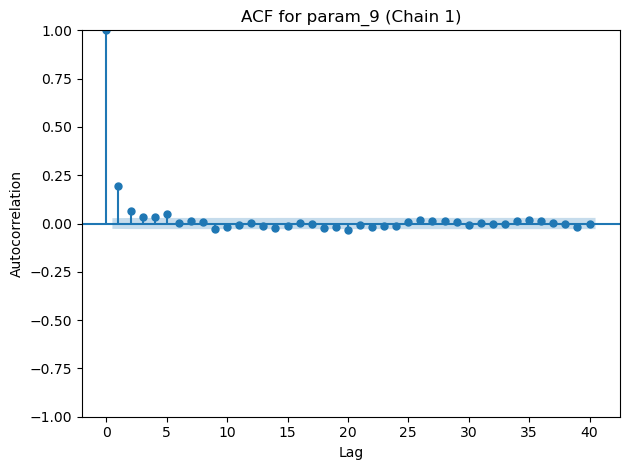

In [10]:
single_chain_samples = loaded_samples_chain1  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)

# 真实值
param_names = sorted(list(single_chain_samples.keys()))
true_params_tensor = test_x[34]
true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}

# 诊断和可视化
for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()
    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()